<a href="https://colab.research.google.com/github/SeongwonTak/TIL_swtak/blob/master/DataScience/210131_Ensemble_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 210131 Ensemble 2

어제에 이어 배깅과 부스팅에 대해 조금 더 정리해보려고 한다.
특히 부스팅을 중심으로 scoring이 무엇인지 정리 후
**XGBoost 모델에** 대해서 간단히 개요 및 코드 예시를 확인해보고자 한다.

# 1. 배깅과 부스팅의 차이 정리
다시 한 번, 배깅과 부스팅의 차이를 정리하려고 한다.
 - 배깅 : 서로 독립적인 N개의 분류기에 전체 표본에서 임의로 추출된 표본을 학습시켜 다수결로 최종 분류를 결정한다.

 - 부스팅 : 약한 분류기에서 잘못 분류된 sample에 가중치를 변경하여 재학습시킨다.

 여기서 의문이 드는 점은 대체 '가중치'를 부여하고 변경하는 것이 무엇을 의미하는지에 대해 고려해야 할 것이다.


 부스팅의 경우에는 가중치 함수를 새로 부여하기에, 최종 결과값이 0, 1로 나누어지는 것이 아닌 0과 1 (혹은 -1과 1) 사이의 어떤 실수로 반환이 될 것이다.
 

## 2. 부스팅 알고리즘의 구체적 순서
부스팅 알고리즘 그 중 어제 확인해본 Adaboost를 통하여 가중치를 적용한다는 것이 대체 무슨 말인지 확인해 보려고 한다.

구체적인 순서는 다음과 같다.

- 1단계 : 가중치 벡터 $w$를 모두 동일한 가중치가 되게 설정한다.
- 2단계 : 다음 과정을 부스팅 횟수동안 반복한다.
  * a. 가중치가 부여된 약한 학습기를 훈련한다.
  $$ C_{j} = train(X, y, w)$$
  * b. 예측 실시. 
  $$ \hat{y} = predict(C_{j}(X))$$
  * c. 에러율 계산
  $$ \epsilon = w \cdot (\hat{y} \neq y)$$
  * d. 학습기 결과 바탕 학습기 가중치 $a_{j}$ 계산
  * e. 학습기 가중치 바탕으로  최종 가중치 업데이트
  * f. 정규화 실시. (**가중치의 합은 1이 되어야 한다**)
- 3단계 : 최종 예측을 계산한다.


## 3. XGBoost의 개요와 사용법.

eXtreme Gradient Boost, **XGBOOST**란, Gradient라는 말이 들어가는 것처럼, 기본적으로는 '**경사하강법**'을 기반으로, 가중치를 최적화 시키는 Boost 방법이다.

XGBoost의 경우는 Regularization이라는 과정을 통해 모델에 제약을 걸어 과적합을 방지한다.

정확하게는 최적화 할려는 목적 함수를 다음과 같이 표기 가능하다.
$$ obj(\theta) = L(\theta) + \Omega(\theta)$$

여기서 $L$은 loss,  $\Omega$는 Regularization term에 해당된다.

구체적인 수학적 배경은 추후 자세한 예시와 함께 정리하려고 한다.

오늘은 일단 코드를 통해 사용법을 알아보자.
XGBoost의 경우는 별도의 패키지가 존재한다.

In [2]:
# Data Loding. Our Friend, Iris.
import numpy as np
import pandas as pd
import seaborn as sns

iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris.data = iris.drop('species', axis = 1)
iris.target = iris['species']

# TVT, 예제에서는 validation은 생략하자.
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(iris.data, iris.target,
                                                       test_size=0.3,  random_state=11)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [7]:
#코드를 숫자로 남기기 위해.

import xgboost as xgb
from xgboost import plot_importance

y_dict = dict(zip(y_train.unique(), range(len(y_train.unique()))))
labels = y_train.unique()
y_train_num = []
for y in y_train:
  y_train_num.append(y_dict[y])

In [8]:
dtrain = xgb.DMatrix(data = np.array(X_train), label = y_train_num)
dtest = xgb.DMatrix(data=np.array(X_test))

random forest랑 다른 점은.. (정확히는 sklearn) 여기서는 Hyper-parameter를 직접 dict로 정의해야 한다.


In [9]:
params = { 'max_depth': 2,                      # 트리 최대 깊이
           'learning_rate': 0.01,               # 학습률, 경사하강법의 이동정도.
           'n_estimators': 50,                  # 트리의 갯수
           'objective':'multi:softmax',         # 목적 함수
           'num_class': 3}  # 클래스의 개수

In [10]:
xgb_model = xgb.train(params = params, dtrain = dtrain)

In [12]:
y_test_num = []
for y in  y_test:
  y_test_num.append(y_dict[y])

# 모델이 예상한 결과 반환
predict = xgb_model.predict(dtest)
accuracy = sum(predict == y_test_num)/len(y_test_num)
# 반환된 예측 데이터와 실제 데이터간의 비교로 정확도 계산
print("정확도: {0:.4f}".format(accuracy))

정확도: 0.8444


변수별로 중요도 또한 그래프 출력 가능하다.

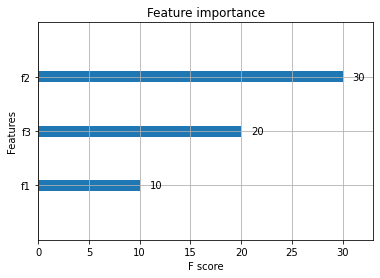

In [15]:
# 위의 그래프 순서대로 f0~f3 배정, f0 = 0이어서 안나옴.
import matplotlib.pyplot as plt

plot_importance(xgb_model)
plt.show()